In [1]:

import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [4]:

def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message



In [5]:

def getDataPointios(line):
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
        date, time = dateTime.split(',')
    else:
        date, time = dateTime.split(' ')
    message = ' '.join(splitLine[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    if time[5]==":":
        time = time[:5]+time[-3:]
    else:
        if 'AM' in time or 'PM' in time:
            time = time[:6]+time[-3:]
        else:
            time = time[:6]
    return date, time, author, message

In [6]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [7]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'C:/Users/Apoorva/Documents/ML Practice/WhatsApp_Breathe.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None #message contains 4 things-"date","time","author","message" 
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line): 
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

9/8/20, 4:11 PM - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [8]:

if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [9]:
df.head()

,Date,Time,Author,Message,emoji,urlcount
2,2020-09-08,6:35 PM,Seema Goel,This message was deleted,[],0
3,2020-09-08,6:35 PM,Seema Goel,This message was deleted,[],0
5,2020-09-08,8:47 PM,Seema Goel,"Welcome Participants! I am Seema, your Senior...",[],0
6,2020-09-08,8:48 PM,+91 6300 874 928,"Thanku Seema mam ,is it 2 level or due to ove...",[],0
7,2020-09-08,8:48 PM,+91 90292 84610,Thanks,[],0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 2 to 1847
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1749 non-null   datetime64[ns]
 1   Time      1749 non-null   object        
 2   Author    1749 non-null   object        
 3   Message   1749 non-null   object        
 4   emoji     1749 non-null   object        
 5   urlcount  1749 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 95.6+ KB


In [11]:
df.Author.unique()

array(['Seema Goel', '+91 6300 874 928', '+91 90292 84610',
       '+91 95600 91199', '+91 94492 65631', '+91 85100 46768',
       '+91 98408 41614', '+91 99894 75724', '+91 97350 90632',
       '+91 98183 64999', '+1 (937) 825-1743', '+91 90549 19966',
       '+91 98211 35352', '+91 94005 46338', '+91 99103 94124',
       '+91 98115 12965', 'Aditya Breathe', '+91 99585 99063',
       '+91 90072 71005', '+91 93038 70700', 'Nitin', '+91 98919 09051',
       '+91 86972 78468', 'Rohan Verma', '+91 99717 58655',
       'Srishti Sanya', '+91 99101 62661', '+91 96866 91334',
       '+91 96502 36333', '+91 97174 64621', '+91 97110 20005',
       '+1 (669) 255-7217', 'Shaurya Breathe', '+91 98917 67508',
       '+91 97080 97211', '+91 86370 36339', '+91 97954 24353',
       '+91 73472 88258', '+91 98230 25957', 'Dashmeet Sachdeva BWB',
       'Isha Kakkar Coach', '+91 88799 78723', 'Vaibhav BWB',
       'Sakshi Sharma', 'Praveen Sharma BWB', '+91 98290 60772',
       '+91 94162 07042', '+91 93

In [12]:

df = df.dropna() #drops all null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 2 to 1847
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1749 non-null   datetime64[ns]
 1   Time      1749 non-null   object        
 2   Author    1749 non-null   object        
 3   Message   1749 non-null   object        
 4   emoji     1749 non-null   object        
 5   urlcount  1749 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 95.6+ KB


In [13]:

total_messages = df.shape[0]
print(total_messages)

1749


In [14]:

media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [15]:

emojis = sum(df['emoji'].str.len()) 
print(emojis)

607


In [16]:
URLPATTERN = r'(https?://\S+)' #regex pattern matching with start with https
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() #return url which matches with pattern and count it through lambda function
links = np.sum(df.urlcount) #sumup all the links
print(links)

0


In [17]:

link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [18]:
messages_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1239 entries, 2 to 1845
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1239 non-null   datetime64[ns]
 1   Time      1239 non-null   object        
 2   Author    1239 non-null   object        
 3   Message   1239 non-null   object        
 4   emoji     1239 non-null   object        
 5   urlcount  1239 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 67.8+ KB


In [19]:

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' '))) #word is calculated by spliting sentence by whitespace
messages_df["MessageCount"]=1

In [28]:
messages_df.head(40)


,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount,emojicount
2,2020-09-08,6:35 PM,Seema Goel,This message was deleted,[],0,25,5,1,0
3,2020-09-08,6:35 PM,Seema Goel,This message was deleted,[],0,25,5,1,0
5,2020-09-08,8:47 PM,Seema Goel,"Welcome Participants! I am Seema, your Senior...",[],0,787,132,1,0
6,2020-09-08,8:48 PM,+91 6300 874 928,"Thanku Seema mam ,is it 2 level or due to ove...",[],0,54,12,1,0
7,2020-09-08,8:48 PM,+91 90292 84610,Thanks,[],0,7,2,1,0
8,2020-09-08,8:48 PM,+91 6300 874 928,I mean 2nd level,[],0,17,5,1,0
9,2020-09-08,8:48 PM,+91 95600 91199,Thanks,[],0,7,2,1,0
10,2020-09-08,8:48 PM,+91 6300 874 928,Phase,[],0,6,2,1,0
11,2020-09-08,8:55 PM,+91 94492 65631,Thanks,[],0,7,2,1,0
12,2020-09-08,9:01 PM,+91 85100 46768,Thank you😊,[😊],0,11,3,1,1


In [38]:
messages_df[messages_df['Date']=="2020-09-08"].sum()


Time            6:35 PM6:35 PM8:47 PM8:48 PM8:48 PM8:48 PM8:48...
Author          Seema GoelSeema GoelSeema Goel+91 6300 874 928...
Message          This message was deleted This message was del...
emoji                                                [😊, 🙏, 🙏, 😊]
urlcount                                                        0
Letter_Count                                                 1147
Word_Count                                                    215
MessageCount                                                   17
emojicount                                                      4
dtype: object

In [21]:
#No of messages by Date
table_dau = pd.pivot_table(messages_df[messages_df['Date']=="2020-09-08"], values='MessageCount', index=['Date'],
                     aggfunc=np.sum)
table_dau.sort_values(by='MessageCount', ascending=False).head(10)

,MessageCount
Date,
2020-09-08,17


In [30]:
#No of Authors/DAU on date
table_dau = pd.pivot_table(messages_df[messages_df['Date']=="2020-09-08"], values='Author', index=['Date'],
                     aggfunc=lambda x: len(x.unique()))
table_dau.head()

,Author
Date,
2020-09-08,13


In [ ]:
#No of Authors/DAU on date
table_dau = pd.pivot_table(messages_df[messages_df['Date']=="2020-09-08"], values='Author', index=['Date'],
                     aggfunc=lambda x: len(x.unique()))
messages_df[messages_df['Date']=="2020-09-08"]

In [32]:
#No of Authors/DAU Datewise
table_dau = pd.pivot_table(messages_df, values='Author', index=['Date'],
                     aggfunc=lambda x: len(x.unique()))
table_dau.head(10)

,Author
Date,
2020-09-08,13
2020-09-09,19
2020-09-10,16
2020-09-11,21
2020-09-12,12
2020-09-13,14
2020-09-14,23
2020-09-15,11
2020-09-16,18


In [29]:

#No of messages by Date
table_dau = pd.pivot_table(messages_df, values='MessageCount', index=['Date'],
                     aggfunc=np.sum)
table_dau.sort_values(by='MessageCount', ascending=False).head(10)
    

,MessageCount
Date,
2020-10-13,46
2020-09-18,43
2020-09-09,42
2020-10-14,41
2020-09-14,38
2020-09-16,35
2020-10-29,35
2020-10-25,35
2020-09-13,30


In [21]:
messages_df["emojicount"]= df['emoji'].str.len()


Author wise


In [23]:
# count_messages={}
# for each in messengers:
#     if each in count_messages.keys():
#         count_messages[each]+=1
#     else:
#         count_messages[each]=1
# count_messages

In [34]:
frnds = messages_df.Author.unique()

for i in range(len(frnds)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == frnds[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {frnds[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == frnds[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == frnds[i]]["urlcount"])   
  print('Links Sent', links)   
  print()


Stats of Seema Goel -
Messages Sent 259
Words per message 77.02702702702703
Media Messages Sent 302
Emojis Sent 105
Links Sent 0

Stats of +91 6300 874 928 -
Messages Sent 38
Words per message 6.157894736842105
Media Messages Sent 8
Emojis Sent 2
Links Sent 0

Stats of +91 90292 84610 -
Messages Sent 12
Words per message 2.3333333333333335
Media Messages Sent 6
Emojis Sent 4
Links Sent 0

Stats of +91 95600 91199 -
Messages Sent 33
Words per message 15.454545454545455
Media Messages Sent 12
Emojis Sent 15
Links Sent 0

Stats of +91 94492 65631 -
Messages Sent 15
Words per message 2.6666666666666665
Media Messages Sent 5
Emojis Sent 0
Links Sent 0

Stats of +91 85100 46768 -
Messages Sent 1
Words per message 3.0
Media Messages Sent 1
Emojis Sent 1
Links Sent 0

Stats of +91 98408 41614 -
Messages Sent 17
Words per message 6.823529411764706
Media Messages Sent 3
Emojis Sent 5
Links Sent 0

Stats of +91 99894 75724 -
Messages Sent 4
Words per message 2.25
Media Messages Sent 0
Emojis Sent

In [25]:
#No of messages by each user
table = pd.pivot_table(messages_df, values='MessageCount', index=['Author'],
                     aggfunc=np.sum)
table.sort_values(by='MessageCount', ascending=False).head(10)

,MessageCount
Author,
Seema Goel,259
Rohan Verma,67
+91 98115 12965,61
+91 86972 78468,57
Srishti Sanya,42
+91 99103 94124,40
+91 6300 874 928,38
+91 90078 84004,35
+91 99585 99063,35


In [29]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)


63


In [30]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('🌟', 110), ('👏', 56), ('🙏🏻', 55), ('👍', 44), ('👍🏻', 34), ('👏🏻', 31), ('🙂', 30), ('💯', 28), ('🤓', 25), ('🙏', 19), ('😊', 13), ('🥜', 12), ('👌🏻', 12), ('😀', 10), ('🙌', 8), ('🤩', 7), ('😞', 7), ('👫', 6), ('🏃🏻\u200d♂️', 6), ('🚶\u200d♂️', 6), ('🥙', 6), ('💪🏻', 6), ('💐', 6), ('👌', 4), ('🙌🏻', 4), ('👏🏼', 4), ('🔥', 3), ('🌸', 3), ('☀️', 3), ('🌹', 3), ('😋', 2), ('💥', 2), ('💫', 2), ('✨', 2), ('🎉', 2), ('🥳', 2), ('😇', 2), ('🏆', 2), ('🥗', 2), ('🏃\u200d♀️', 2), ('🙋\u200d♂️', 2), ('💪', 2), ('🖐🏻', 2), ('👆', 1), ('😯', 1), ('😦', 1), ('😫', 1), ('😲', 1), ('♥️', 1), ('😭', 1), ('😄', 1), ('🌺', 1), ('😍', 1), ('🏋🏼', 1), ('🖼️', 1), ('✅', 1), ('💕', 1), ('🙋🏻\u200d♂️', 1), ('😃', 1), ('🧠', 1), ('🤝', 1), ('👆🏻', 1), ('👍🏼', 1)]


In [31]:

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,🌟,110
1,👏,56
2,🙏🏻,55
3,👍,44
4,👍🏻,34
...,...,...
58,😃,1
59,🧠,1
60,🤝,1
61,👆🏻,1


In [26]:

# import plotly.express as px
# fig = px.pie(emoji_df, values='count', names='emoji')
# fig.update_traces(textposition='inside', textinfo='percent+label')
# fig.show()

Text(0, 0.5, 'Time')

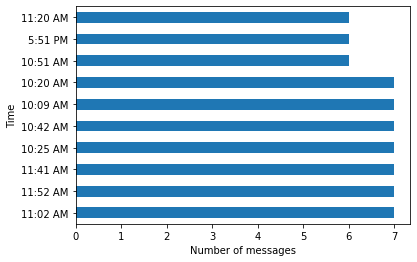

In [33]:

messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

In [ ]:
#DAU
